# Variational Bayes: A Gentle Introduction 

## PyMC3 Code

This example of variational inference with PyMC3 is based on [this blogpost](https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/#model-inference-using-variational-inference-mini-batch-advi)

The slides of the talk can be found [here](https://www.slideshare.net/FlavioMorelli1/variational-bayes-a-gentle-introduction)

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano
import warnings
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

sns.set(font_scale=1.5)
warnings.filterwarnings("ignore")

Estimate the model:

$y = \alpha + \beta x + \epsilon$

where:

$y \sim N(\alpha + \beta x, \sigma)$ 

$\alpha \sim G^{-1}(1, 1)$

$\beta \sim N(0, 4)$

$\sigma \sim G^{-1}(1, 1)$

# Data simulation

In [3]:
alpha = 1
beta = 1
sigma = 0.75

,y,x
0,3.467761,2.322747
1,8.382031,7.806289
2,1.069032,0.090593
3,2.051421,0.343138
4,7.109246,5.242832


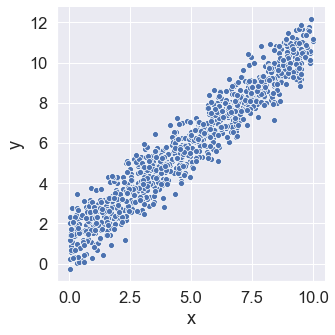

In [4]:
n_samples = 1000

x = uniform(low=0, high=10, size=n_samples)

y = alpha + beta * x + sigma * randn(n_samples)
     
model_data = pd.DataFrame({'y': y, 'x': x})

display(model_data.head())
data_plot = sns.relplot(x='x', y='y', data=model_data)

data_plot.savefig("plots/data.jpg")

In [5]:
train, test = train_test_split(model_data, test_size=0.2)

In [6]:
y_train = theano.shared(train.y.values.astype('float64'))
x_train = theano.shared(train.x.values.astype('float64'))

In [7]:
x_train.get_value().shape

(800,)

In [8]:
with pm.Model() as model:
    alpha_prior = pm.InverseGamma('alpha', alpha=1, beta=1)
    beta_prior = pm.Normal('beta', mu=0, sd=2)
    sigma_prior = pm.InverseGamma('sigma', alpha=1, beta=1)
    mu_likelihood = alpha_prior + beta_prior * x_train 
    y = pm.Normal('y', mu=mu_likelihood, sd=sigma_prior, observed=y_train)

In [9]:
with model:
    hmc_trace = pm.sample(draws=2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:08<00:00, 673.94draws/s]


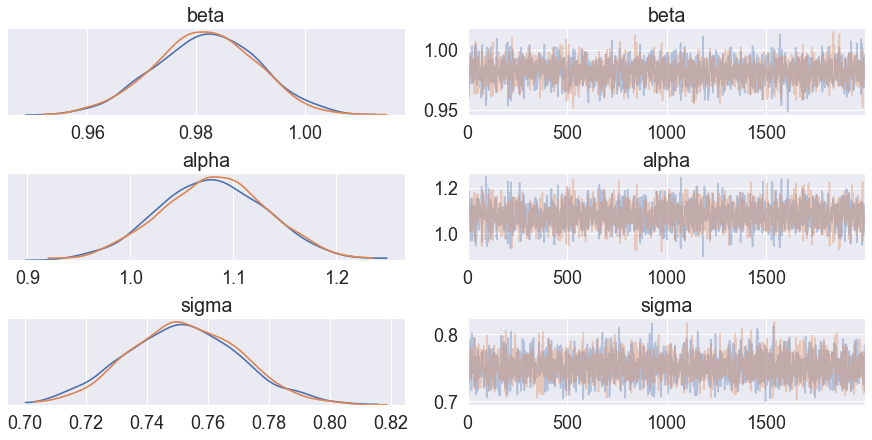

In [10]:
hmc_plot = pm.traceplot(hmc_trace, textsize=18)

In [11]:
pm.summary(hmc_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.981659,0.009449,0.000210,0.963123,1.000075,2144.423167,1.000253
alpha,1.080160,0.052605,0.001173,0.971331,1.177402,2102.920386,1.000174
sigma,0.751865,0.018595,0.000330,0.715213,0.788210,2914.876597,1.000566


## ADVI

In [13]:
with model:
    advi_fit = pm.fit(method="advi", n=30000)

Average Loss = 919.47: 100%|██████████| 30000/30000 [00:24<00:00, 1233.34it/s]   
Finished [100%]: Average Loss = 919.47


,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta,0.981278,0.007068,0.000063,0.967067,0.995101
alpha,1.076537,0.039446,0.000410,0.998496,1.154536
sigma,0.751911,0.021291,0.000189,0.711625,0.793949


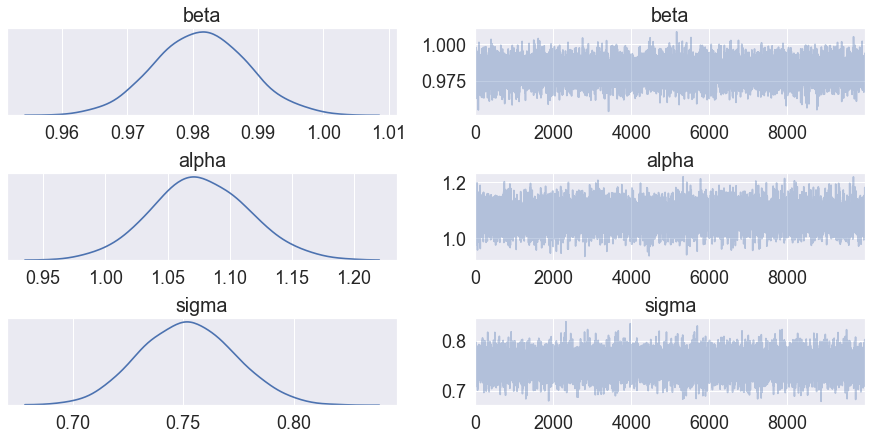

In [14]:
advi_trace = advi_fit.sample(10000)
pm.traceplot(advi_trace, textsize=18)
pm.summary(advi_trace)

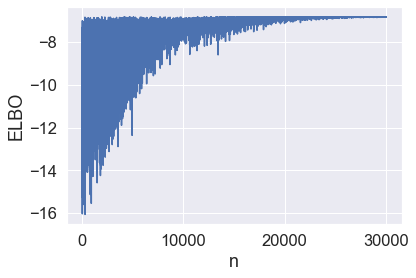

In [15]:
# Plot ELBO maximization

advi_elbo = pd.DataFrame(
    {'ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

elbo_plot = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

## Fullrank ADVI

In [16]:
with model:
    fr_advi_fit = pm.fit(method="fullrank_advi", n=30000)

Average Loss = 918.19: 100%|██████████| 30000/30000 [00:36<00:00, 819.93it/s]   
Finished [100%]: Average Loss = 918.19


,mean,sd,mc_error,hpd_2.5,hpd_97.5
beta,0.981952,0.010622,0.000101,0.961298,1.002595
alpha,1.082512,0.052693,0.000510,0.982374,1.184397
sigma,0.753893,0.020924,0.000226,0.714978,0.796689


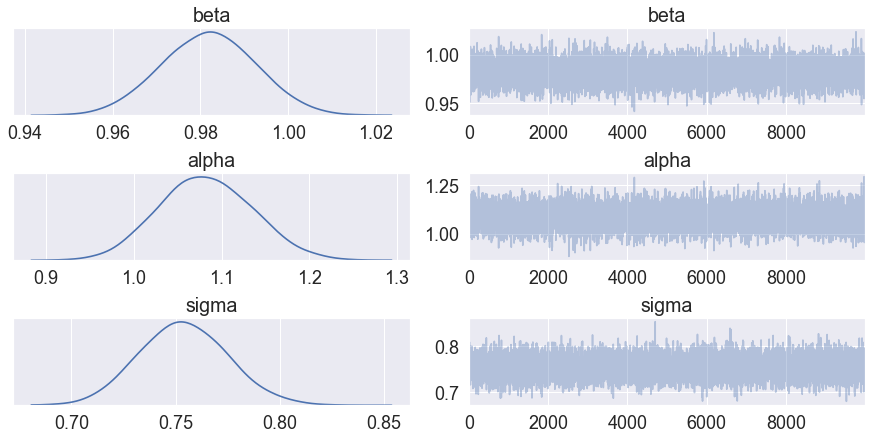

In [17]:
fr_advi_trace = fr_advi_fit.sample(10000)
pm.traceplot(fr_advi_trace, textsize = 18)
pm.summary(fr_advi_trace)

# Correlation between parameters

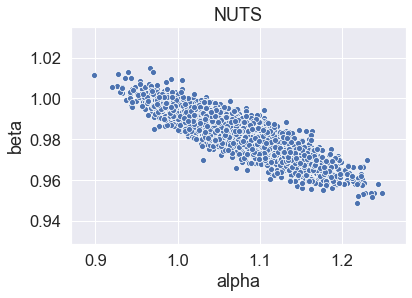

In [18]:
param_samples_HMC = pd.DataFrame(
    {'alpha': hmc_trace.get_values('alpha'), 
     'beta': hmc_trace.get_values('beta')})

hmc_corr = sns.scatterplot(x='alpha', y='beta', data=param_samples_HMC).set_title("NUTS").get_figure()
hmc_corr.savefig("plots/hmc_corr.jpg")

With the mean-field assumption, the correlation between parameters is not captured

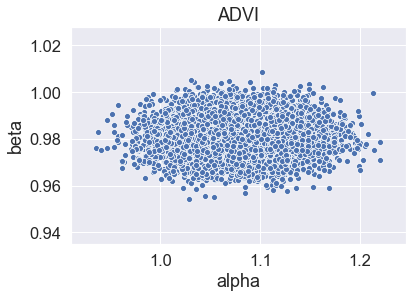

In [19]:
# Mean-field assumption at work
param_samples_ADVI = pd.DataFrame(
    {'alpha': advi_trace.get_values('alpha'), 
     'beta': advi_trace.get_values('beta')})

advi_corr = sns.scatterplot(x='alpha', y='beta', data=param_samples_ADVI).set_title('ADVI').get_figure()
advi_corr.savefig("plots/advi_corr.jpg")

Full rank ADVI captures the correlation structure of the parameters

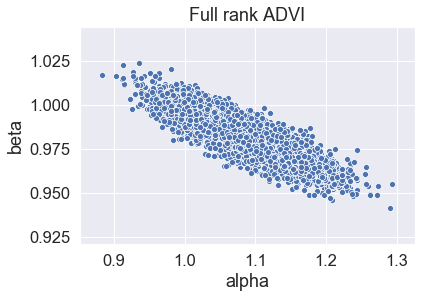

In [20]:
# Fullrank ADVI correlation
param_samples_FR_ADVI = pd.DataFrame(
    {'alpha': fr_advi_trace.get_values('alpha'), 
     'beta': fr_advi_trace.get_values('beta')})

fr_advi_corr = sns.scatterplot(x='alpha', y='beta', data=param_samples_FR_ADVI).set_title('Full rank ADVI').get_figure()
fr_advi_corr.savefig("plots/fr_advi_corr.jpg")